In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [51]:
# Fecthing private data
messages = pd.read_csv('databases/private-data/messages.csv')
order = pd.read_csv('databases/private-data/order.csv')
sensors = pd.read_csv('databases/private-data/sensors.csv')

# Fetching public data
public = pd.read_csv('databases/public.csv')

## Important Info about each table
#### Table: messages.csv

 - AC: Coluna usada para identificar a aeronave
 - FLIGHT: Identificador do voo (coluna única na tabela)
 - TIME: Tempo relativo ao inicio do voo em que a mensagem foi emitida (em segundos)
 - FLIGHT_PHASE: Fase do voo no qual a mensagem foi enviada
 - TYPE: Tipo de mensagem enviada
 - MESSAGE: Corpo da mensagem enviada
 
#### Table: sensors.csv
 
 - AC: Coluna usada para identificar a aeronave 
 - FLIGHT: Identificador do voo (coluna única na tabela)
 - TIME: Tempo relativo ao início do voo no qual foi feito a leitura do sensor
 - [AMBIENT_1 (...) PAR_SYS_3]: Sensores e suas leituras
 
#### Table: public.csv

 - FLIGHT: Identificador do voo
 - MAINTENANCE: Indica o número de dias que faltam para se realizar uma manutenção (rótulo do modelo)
 
__The goal of this model is to predict the number of days until maintenence for the flights that are listed in the sensors table, but not on the public table__

In [59]:
# Output example
public.head(10)

,FLIGHT,MAINTENANCE
0,00055a,14
1,006042,4
2,0192d1,8
3,01b892,13
4,01e2f1,10
5,0202b8,3
6,022f92,2
7,036b8c,11
8,036d23,12
9,03896c,9


In [75]:
# Exploring data about flight number 00055a
target_flight = '036d23'
target_days = int(public[public['FLIGHT'] == target_flight]['MAINTENANCE'])

# Messages
aux_msg = messages[messages['FLIGHT'] == target_flight]

# Sensors
aux_sen = sensors[sensors['FLIGHT'] == target_flight]

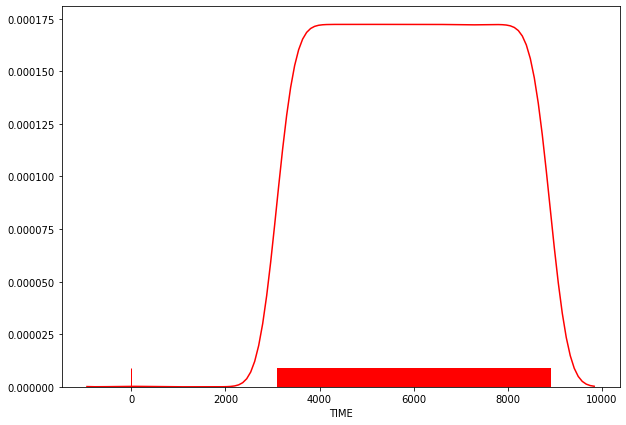

In [98]:
# Sensors readings distribuited with time
f, axes = plt.subplots(figsize=(10, 7))
sns.distplot(aux_sen['TIME'],hist=False,rug=True,color='r')

In [24]:
# 10 first lines
messages.head(10)

,AC,FLIGHT,TIME,FLIGHT_PHASE,TYPE,MESSAGE
0,AC19,03896c,105,2,FDE,120
1,AC19,03896c,4890,3,FDE,120
2,AC19,03d505,3454,2,FDE,120
3,AC19,03d505,6048,3,FDE,120
4,AC19,03d505,8307,2,FDE,120
5,AC19,03d505,45003,2,FDE,120
6,AC19,05fd40,127,2,FDE,120
7,AC19,05fd40,5354,3,FDE,120
8,AC19,05fd40,5848,2,FDE,120
9,AC19,06c13f,1583,2,FDE,120


In [45]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147564 entries, 0 to 147563
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   AC            147564 non-null  object
 1   FLIGHT        147564 non-null  object
 2   TIME          147564 non-null  int64 
 3   FLIGHT_PHASE  147564 non-null  int64 
 4   TYPE          147564 non-null  object
 5   MESSAGE       147564 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 6.8+ MB


In [47]:
messages['FLIGHT_PHASE'].value_counts()

2    90404
3    27606
6    14427
5     8115
7     3556
4     3120
8      336
Name: FLIGHT_PHASE, dtype: int64

In [44]:
messages['AC'].value_counts()

AC19    37781
AC22    28050
AC24    23106
AC29    15434
AC35    15129
AC32    13123
AC30     6127
AC21     4470
AC23     4344
Name: AC, dtype: int64

In [49]:
messages['MESSAGE'].value_counts()

120     96844
4713    18620
4755    10868
4717     4529
126      2227
        ...  
5122        4
4744        3
5125        2
5305        2
5299        1
Name: MESSAGE, Length: 87, dtype: int64

In [50]:
messages['TYPE'].value_counts()

FDE    104049
MM      43515
Name: TYPE, dtype: int64

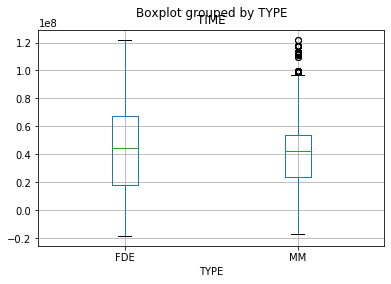

In [41]:
messages.boxplot(column="TIME",by="TYPE")

KeyError: "None of [Index(['FLIGHT'], dtype='object')] are in the [columns]"

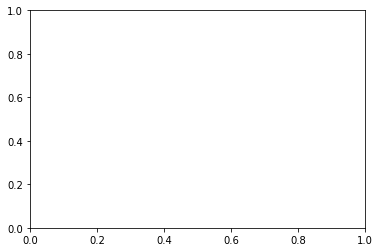

In [31]:
messages.boxplot(column="FLIGHT")

In [10]:
order.head()

,FLIGHT,BEFORE
0,00055a,6486f3
1,006042,3f52d9
2,00f1a7,21a675
3,0192d1,1c793f
4,01b892,a2838a


In [11]:
sensors.head()

,AC,FLIGHT,TIME,AMBIENT_1,PAR_AC_1,PAR_AC_2,PAR_AC_3,PAR_AC_4,PAR_SYS_1,PAR_SYS_2,...,WAR_SYS_1,COM_SYS_1,PAR_SYS_9,PAR_SYS_10,PAR_SYS_5,WAR_SYS_2,PAR_SYS_6,WAR_SYS_3,PAR_SYS_7,PAR_SYS_8
0,AC19,006042,0,11720.0,44.18250,40.92875,0,0,69.000,285.0,...,0,0,0.0,0.0,1.0,0,1,0,225.7875,132.300
1,AC19,006042,1,11720.0,42.98375,40.07250,0,0,69.000,287.0,...,0,0,0.0,0.0,1.0,0,1,0,225.7875,132.300
2,AC19,006042,2,11720.5,42.98375,40.07250,0,0,69.000,287.0,...,0,0,0.0,0.0,1.0,0,1,0,112.7250,132.300
3,AC19,006042,3,11720.5,42.98375,40.07250,0,0,67.500,287.0,...,0,0,0.0,0.0,1.0,0,1,0,112.7250,124.875
4,AC19,006042,3060,11724.0,0.00000,0.00000,0,0,66.625,246.0,...,0,0,0.0,0.0,0.0,0,0,0,79.6500,0.000
